In [ ]:
import json
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import cudaq
from openfermionpyscf import run_pyscf
from openfermion import MolecularData
from openfermion.transforms import jordan_wigner, get_fermion_operator
from openfermion import QubitOperator
import random
import time
import torch.optim as optim
import copy
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from torch.utils.data import Dataset, DataLoader

cudaq.set_target('nvidia')
device = torch.device("cuda")


In [ ]:

# === Build CUDA-Q Spin Hamiltonian from Pauli strings and coefficients === based on THIS dataset
def build_spin_hamiltonian(pauli_words, coeffs):
    qubit_op = QubitOperator()
    for pw, c in zip(pauli_words, coeffs):
        # Identity
        if pw == "()" or pw == "":
            qubit_op += QubitOperator('', c)
        else:
            # Parse string like "((0, 'Z'), (1, 'Z'))" into a usable Pauli string
            parsed = eval(pw)  
            pauli_str = ' '.join([f"{p}{i}" for (i, p) in parsed])
            qubit_op += QubitOperator(pauli_str, c)
    return cudaq.SpinOperator(qubit_op)



def make_cudaq_kernel(n_qubits, n_electrons):
    @cudaq.kernel
    def kernel(thetas: list[float], n_electrons: int, n_qubits: int):
        qubits = cudaq.qvector(n_qubits)
        for i in range(n_electrons):
            x(qubits[i])
        cudaq.kernels.uccsd(qubits, thetas, n_electrons, n_qubits)
    return kernel

def max_cudaq_params(mol):
    return cudaq.kernels.uccsd_num_parameters(mol["n_electrons"], mol["n_qubits"])




def make_vqe_cost_fn(cudaq_kernel, spin_ham, param_dim, n_electrons, n_qubits, shift=1e-2):
    class VQECostFunction(torch.autograd.Function):
        @staticmethod
        def forward(ctx, params):
            ctx.param_dim = param_dim
            ctx.cudaq_kernel = cudaq_kernel
            ctx.spin_ham = spin_ham
            ctx.n_electrons = n_electrons
            ctx.n_qubits = n_qubits
            ctx.shift = shift
            ctx.save_for_backward(params)
            params_np = params.detach().cpu().view(-1).numpy()[:param_dim]
            result = cudaq.observe(cudaq_kernel, spin_ham, params_np, n_electrons, n_qubits)
            value = result.expectation() 
            return (params.sum() * 0) + params.new_tensor([float(value)])




        @staticmethod
        def backward(ctx, grad_output):
            params, = ctx.saved_tensors
            grad = torch.zeros_like(params)
            shift = ctx.shift
            for i in range(ctx.param_dim):
                shift_vec = torch.zeros_like(params)
                shift_vec[0, i] = shift
                plus = params + shift_vec
                minus = params - shift_vec
                plus_val = cudaq.observe(ctx.cudaq_kernel, ctx.spin_ham, plus.detach().cpu().view(-1).numpy()[:ctx.param_dim], ctx.n_electrons, ctx.n_qubits).expectation()
                minus_val = cudaq.observe(ctx.cudaq_kernel, ctx.spin_ham, minus.detach().cpu().view(-1).numpy()[:ctx.param_dim], ctx.n_electrons, ctx.n_qubits).expectation()
                grad[0, i] = (plus_val - minus_val) / (2 * shift)
            return grad * grad_output,
    def vqe_cost(params):
        if not isinstance(params, torch.Tensor):
            params = torch.tensor(params, dtype=torch.float32).unsqueeze(0)
        return VQECostFunction.apply(params)
    return vqe_cost


In [ ]:

class MetaFCLSTMFCAdapter(nn.Module):
    def __init__(self, input_dim, hidden_dim, backbone_dim, output_dim):
        super().__init__()
        self.input_adapter = nn.Linear(input_dim, backbone_dim)
        self.fc1 = nn.Linear(backbone_dim, hidden_dim)
        self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, backbone_dim)
        self.output_adapter = nn.Linear(backbone_dim, output_dim)

    def forward(self, x, hx=None, cx=None):
        x = self.input_adapter(x)
        x = torch.relu(self.fc1(x))
        if hx is None or cx is None:
            hx = torch.zeros(x.size(0), self.lstm_cell.hidden_size, device=x.device)
            cx = torch.zeros(x.size(0), self.lstm_cell.hidden_size, device=x.device)
        hx, cx = self.lstm_cell(x, (hx, cx))
        x = torch.relu(self.fc2(hx))
        out = self.output_adapter(x)
        return out, hx, cx



In [ ]:

def rnn_iteration_padded(prev_cost, prev_params, prev_h, prev_c, model, cost_fn, param_dim, max_param_dim, device):
    # Pad prev_params to max_param_dim
    params_padded = torch.zeros(1, max_param_dim, device=device)
    params_padded[:, :param_dim] = prev_params[:, :param_dim]
    rnn_input = torch.cat([params_padded, prev_cost], dim=1)  # (1, max_param_dim + 1)
    new_params, new_h, new_c = model(rnn_input, prev_h, prev_c)
    # Only the first param_dim elements are "real"
    _params = new_params[:, :param_dim]
    _cost = cost_fn(_params)
    new_cost = _cost.view(1, 1)
    return new_cost, new_params, new_h, new_c

def recurrent_loop_padded(model, cost_fn, param_dim, max_param_dim, device, n_steps=5):
    # All zeros to start (in padded shape)
    initial_cost = torch.zeros(1, 1, device=device)
    initial_params = torch.zeros(1, param_dim, device=device)
    initial_h = torch.zeros(1, model.lstm_cell.hidden_size, device=device)
    initial_c = torch.zeros(1, model.lstm_cell.hidden_size, device=device)
    costs = []
    cost, params, h, c = initial_cost, initial_params, initial_h, initial_c
    weights = [1.0 for _ in range(n_steps)]
    weights = [w/sum(weights) for w in weights]
    loss = 0
    for i in range(n_steps):
        cost, params, h, c = rnn_iteration_padded(cost, params, h, c, model, cost_fn, param_dim, max_param_dim, device)
        costs.append(cost)
        loss += weights[i] * cost
    loss = loss / sum(weights)
    return loss, costs

# Data Prep


https://arxiv.org/pdf/2503.22590        params = torch.empty(1, param_dim, device=device).uniform_(-0.001, 0.001)

https://arxiv.org/html/2406.08554v1     90%-10% training-validation splits for 25 epochs; large molecule pretrain -> smaller finetune

http://quantum-machine.org/datasets/

dataset: 98 index max; 

H2:   0-37

H3:   38-64

H4:   65-71

H6:   72-78

H8:   79-85

H10:  86-92

OH:   93-98

In [ ]:
with open('dataset.json') as f:
    dataset = json.load(f)  


train_dataset = dataset[67:97]  #H4 H6 H8 H10 OH
train_set, val_set = train_test_split(train_dataset, test_size=0.1, random_state=42)

transfer1 = dataset[:67] + dataset[97:] #H2 H3 H4 OH

# Pretrain Epoch

In [ ]:

hidden_dim = 24
backbone_dim = 32
n_layers = 1

steps = 10
epochs = 3  #越多越好 ~25

max_param_dim = max(cudaq.kernels.uccsd_num_parameters(task['n_electrons'], task['n_qubits']) for task in train_dataset)
input_dim = max_param_dim + 1
output_dim = max_param_dim
meta_optim = MetaFCLSTMFCAdapter(input_dim, hidden_dim, backbone_dim, output_dim).to(device)

optimizer = optim.Adam(meta_optim.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

best_val_loss = float('inf')

for epoch in range(epochs):
    meta_optim.train()
    meta_loss_total = 0.0

    for i, task in enumerate(train_set):
        n_electrons = task['n_electrons']
        n_qubits = task['n_qubits']
        param_dim = cudaq.kernels.uccsd_num_parameters(n_electrons, n_qubits)

        spin_ham = build_spin_hamiltonian(task["pauli_words"], task["hamiltonian_coeffs"])
        cudaq_kernel = make_cudaq_kernel(n_qubits, n_electrons)
        cost_fn = make_vqe_cost_fn(cudaq_kernel, spin_ham, param_dim, n_electrons, n_qubits)

        task_loss, costs = recurrent_loop_padded(
            meta_optim, cost_fn, param_dim, max_param_dim, device, n_steps=steps
        )
        meta_loss_total += task_loss

        if (i + 1) % 5 == 0 or (i + 1) == len(train_set):
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_set)}, Task loss: {task_loss.item():.6f}")

    meta_loss = meta_loss_total / len(train_set)
    optimizer.zero_grad()
    meta_loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Train Meta-loss: {meta_loss.item():.6f}")

    # ------- Validation --------
    meta_optim.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for j, task in enumerate(val_set):
            n_electrons = task['n_electrons']
            n_qubits = task['n_qubits']
            param_dim = cudaq.kernels.uccsd_num_parameters(n_electrons, n_qubits)

            spin_ham = build_spin_hamiltonian(task["pauli_words"], task["hamiltonian_coeffs"])
            cudaq_kernel = make_cudaq_kernel(n_qubits, n_electrons)
            cost_fn = make_vqe_cost_fn(cudaq_kernel, spin_ham, param_dim, n_electrons, n_qubits)

            val_task_loss, _ = recurrent_loop_padded(
                meta_optim, cost_fn, param_dim, max_param_dim, device, n_steps=steps
            )
            val_loss_total += val_task_loss

    val_loss = val_loss_total / len(val_set)
    print(f"Epoch {epoch+1}, Validation Meta-loss: {val_loss.item():.6f}")

    scheduler.step(val_loss)

    # ---- Early stopping logic ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(meta_optim.state_dict(), "model1.pt") 
        print(f"  [*] Best validation loss so far: {best_val_loss.item():.6f} (model saved)")
    else:
        break


In [ ]:
params = torch.zeros(1, param_dim, device=device)
cost = cost_fn(params)
hx = torch.zeros(1, hidden_dim, device=device)
cx = torch.zeros(1, hidden_dim, device=device)

guesses = [params.clone()]
energies = [cost.item()]

for s in range(steps):
    if cost.dim() == 0:
        cost = cost.view(1, 1)
    elif cost.dim() == 1:
        cost = cost.view(1, 1)
        
    if params.dim() == 1:
        params = params.unsqueeze(0)
    params_padded = torch.zeros(1, max_param_dim, device=device)
    params_padded[:, :param_dim] = params
    rnn_input = torch.cat([params_padded, cost], dim=1)

    new_params, hx, cx = meta_optim(rnn_input, hx, cx)
    params = new_params[:, :param_dim]

    cost = cost_fn(new_params)
    guesses.append(new_params.detach())
    energies.append(cost.item())

print("Energies during rollout:", energies)
print("Parameter guesses during rollout:", guesses)


In [ ]:
fig, ax = plt.subplots()

plt.plot(energies, color="blue", lw=3, ls="-.", marker='o', label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks(range(len(energies)))  
plt.show()


# Fine Tune Epoch

In [ ]:
for transfer_task in transfer1:
    param_dim = cudaq.kernels.uccsd_num_parameters(
        transfer_task['n_electrons'], transfer_task['n_qubits']
    )
    n_electrons = transfer_task['n_electrons']
    n_qubits = transfer_task['n_qubits']
    param_dim = cudaq.kernels.uccsd_num_parameters(n_electrons, n_qubits)
    spin_ham = build_spin_hamiltonian(transfer_task["pauli_words"], transfer_task["hamiltonian_coeffs"])
    cudaq_kernel = make_cudaq_kernel(n_qubits, n_electrons)

input_dim = param_dim + 1
output_dim = param_dim
hidden_dim = 24
backbone_dim = 32


meta_optim = MetaFCLSTMFCAdapter(input_dim, hidden_dim, backbone_dim, output_dim).to(device)
#meta_optim.output_adapter = nn.Linear(backbone_dim, output_dim).to(device)
meta_optim.output_adapter = nn.Sequential(
    nn.Linear(backbone_dim, 100),
    nn.ReLU(),
    nn.Linear(100, output_dim)
).to(device)

ckpt = torch.load("model1.pt", map_location=device)
model_dict = meta_optim.state_dict()

backbone_keys = [k for k in ckpt if "fc1" in k or "lstm_cell" in k or "fc2" in k]
filtered_ckpt = {k: ckpt[k] for k in backbone_keys if k in model_dict and ckpt[k].shape == model_dict[k].shape}
model_dict.update(filtered_ckpt)
meta_optim.load_state_dict(model_dict, strict=False)


for param in meta_optim.fc1.parameters(): param.requires_grad = False
for param in meta_optim.lstm_cell.parameters(): param.requires_grad = False
for param in meta_optim.fc2.parameters(): param.requires_grad = False
for param in meta_optim.input_adapter.parameters(): param.requires_grad = False
for param in meta_optim.output_adapter.parameters(): param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, meta_optim.parameters()), lr=1e-5)


vqe_cost = make_vqe_cost_fn(cudaq_kernel, spin_ham, param_dim, n_electrons, n_qubits)

epochs = 5 
steps = 10

for epoch in range(epochs):
    meta_optim.train()
    params = torch.zeros(1, param_dim, device=device)
    cost = torch.zeros(1, 1, device=device)
    hx = torch.zeros(1, hidden_dim, device=device)
    cx = torch.zeros(1, hidden_dim, device=device)

    task_loss = 0.0
    for s in range(steps):
        if cost.dim() == 0 or cost.dim() == 1:
            cost = cost.view(1, 1)
        rnn_input = torch.cat([params, cost], dim=1)
        new_params, hx, cx = meta_optim(rnn_input, hx, cx)
        cost = vqe_cost(new_params)
        params = new_params.detach()
        task_loss += cost
    avg_loss = task_loss / steps

    optimizer.zero_grad()
    avg_loss.backward()
    optimizer.step()
    print(f"[Transfer] Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss.item():.6f}")

print("Transfer learning complete. Only adapters were trained.")

In [ ]:
torch.save(meta_optim.state_dict(), "Transfer.pt")

# Results (H2O)

In [7]:
geometry = [
    ('O', (0.0, 0.0, 0.0)),
    ('H', (0.757, 0.586, 0.0)),
    ('H', (-0.757, 0.586, 0.0))
]

basis = 'sto-3g'
multiplicity = 1
charge = 0

# Build molecule
molecule = MolecularData(geometry, basis, multiplicity, charge)
molecule = run_pyscf(molecule, run_scf=1, run_fci=1)

# Get qubit Hamiltonian
qubit_ham = jordan_wigner(molecule.get_molecular_hamiltonian())

# Pauli words and coeffs for your pipeline:
pauli_words = [str(term) for term in qubit_ham.terms]
coeffs = [qubit_ham.terms[term] for term in qubit_ham.terms]

n_electrons = molecule.n_electrons
n_qubits = molecule.n_qubits  

h2o_mol = {
    'label': 'H2O',
    'n_electrons': n_electrons,
    'n_qubits': n_qubits,
    'pauli_words': pauli_words,
    'hamiltonian_coeffs': coeffs
}

spin_ham = build_spin_hamiltonian(h2o_mol['pauli_words'], h2o_mol['hamiltonian_coeffs'])
param_dim = cudaq.kernels.uccsd_num_parameters(n_electrons, n_qubits)

@cudaq.kernel
def cudaq_kernel(thetas: list[float], n_electrons: int, n_qubits: int):
    qubits = cudaq.qvector(n_qubits)
    for i in range(n_electrons):
        x(qubits[i])
    cudaq.kernels.uccsd(qubits, thetas, n_electrons, n_qubits)

vqe_cost = make_vqe_cost_fn(cudaq_kernel, spin_ham, param_dim, n_electrons, n_qubits)


In [8]:
param_dim = cudaq.kernels.uccsd_num_parameters(h2o_mol['n_electrons'], h2o_mol['n_qubits'])

input_dim = param_dim + 1
output_dim = param_dim
hidden_dim = 24
backbone_dim = 32
meta_optim = MetaFCLSTMFCAdapter(input_dim, hidden_dim, backbone_dim, output_dim).to(device)



# Load checkpoint
ckpt = torch.load("Transfer.pt", map_location=device)
model_dict = meta_optim.state_dict()
# Only update backbone keys (fc1, fc2, lstm_cell), ignore adapters
backbone_keys = [k for k in ckpt if "fc1" in k or "fc2" in k or "lstm_cell" in k]
filtered_ckpt = {k: ckpt[k] for k in backbone_keys if k in model_dict and ckpt[k].shape == model_dict[k].shape}
model_dict.update(filtered_ckpt)
meta_optim.load_state_dict(model_dict, strict=False)
meta_optim.eval()


MetaFCLSTMFCAdapter(
  (input_adapter): Linear(in_features=141, out_features=32, bias=True)
  (fc1): Linear(in_features=32, out_features=24, bias=True)
  (lstm_cell): LSTMCell(24, 24)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (output_adapter): Linear(in_features=32, out_features=140, bias=True)
)

LSTM rollout losses on H2O: [-74.95112609863281, -69.8104019165039, -69.5882339477539, -69.50785827636719, -69.47997283935547, -69.46855926513672, -69.46426391601562, -69.46363067626953, -69.46490478515625, -69.46565246582031, -69.46721649169922, -69.46886444091797, -69.4696044921875, -69.4697494506836, -69.4701919555664, -69.47041320800781, -69.47122192382812, -69.47157287597656, -69.47124481201172, -69.4711685180664, -69.47122192382812]


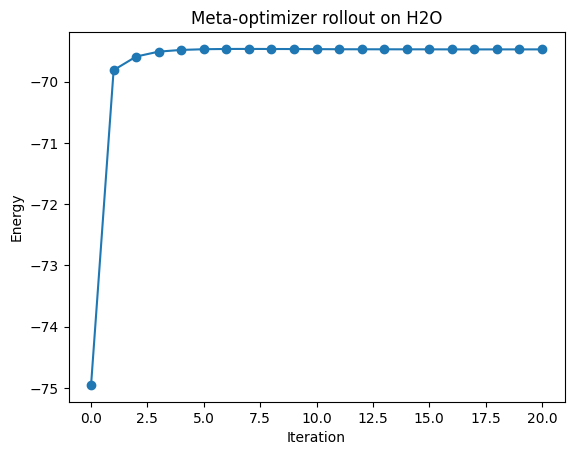

In [9]:
steps = 20
params = torch.empty(1, param_dim, device=device).uniform_(-0.001, 0.001)

cost = vqe_cost(params)
hx = torch.zeros(1, hidden_dim, device=device)
cx = torch.zeros(1, hidden_dim, device=device)

lstm_losses = [cost.item()]
with torch.no_grad():
    for s in range(steps):
        if cost.dim() == 0:
            cost = cost.view(1, 1)
        elif cost.dim() == 1:
            cost = cost.view(1, 1)
        rnn_input = torch.cat([params, cost], dim=1)
        new_params, hx, cx = meta_optim(rnn_input, hx, cx)
        cost = vqe_cost(new_params)
        lstm_losses.append(cost.item())
        params = new_params.detach()

print("LSTM rollout losses on H2O:", lstm_losses)

plt.plot(lstm_losses, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Meta-optimizer rollout on H2O")
plt.show()


Current params: [ 9.15707305e-01 -8.74476433e-02 -5.62755987e-02  6.77869916e-02
  5.21452539e-02  1.38759479e-01  5.04936315e-02  5.40850051e-02
 -9.23395082e-02  1.05108693e-03 -1.09093383e-01 -1.72573730e-01
 -6.16293028e-03 -6.59860000e-02 -2.01597251e-02  4.21513021e-02
 -4.98157404e-02  1.07191712e-01  1.95507050e-01  1.26408666e-01
  1.42560527e-02  7.86280930e-02 -2.89207041e-01 -1.21070527e-01
  1.73065662e-01 -1.48359507e-01 -1.46039307e-01 -1.05530061e-01
  2.13381857e-01 -1.06891990e-03  2.06741076e-02 -8.23364556e-02
 -1.65512815e-01 -1.69583321e-01  2.19656080e-01  4.13100906e-02
 -7.46647939e-02 -2.03417659e-01 -1.33473516e-01  6.36128783e-02
 -1.90685302e-01 -1.31933048e-01 -1.76256165e-01  2.71364838e-01
 -1.79347411e-01 -1.14315726e-01 -1.91016629e-01 -1.27311125e-01
 -4.08647656e-02 -1.40329525e-01 -1.13831766e-01  5.75507656e-02
 -3.04376669e-02  6.86793327e-02  2.10667267e-01 -1.52268022e-01
  9.23149511e-02  1.30390108e-01 -1.92810118e-01 -5.40363081e-02
 -1.45640

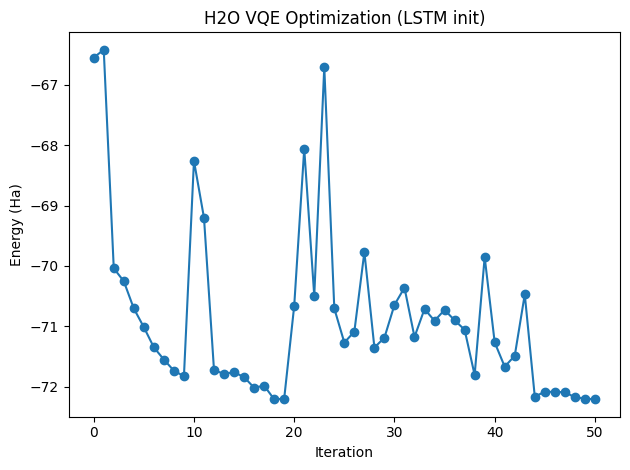

In [10]:

best_params = params.detach().cpu().numpy().flatten()

energy_history = []

# Make sure your vqe_cost is on the correct device (CPU for scipy, or handle device inside vqe_cost)
def cb(params):
    # Convert params (numpy array) to torch tensor, ensure shape is (1, param_dim)
    params_torch = torch.tensor(params, dtype=torch.float32).unsqueeze(0)
    # If your vqe_cost needs a device argument, add .to(device)
    energy = vqe_cost(params_torch).item()
    print("Current params:", params, "Energy:", energy)
    energy_history.append(energy)

# Get initial params (ensure it's a 1D numpy array of correct size)
params_init = np.array(best_params[:param_dim], dtype=np.float32)

# Classical VQE optimization using COBYLA, with LSTM-suggested initialization
result = minimize(
    fun=lambda p: vqe_cost(torch.tensor(p, dtype=torch.float32).unsqueeze(0)).item(),
    x0=params_init,
    method="COBYLA",
    options={"maxiter": 50},
    callback=cb
)

print("Final optimized VQE energy for H2O:", result.fun)

# Plot the energy at each callback step
plt.plot(energy_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H2O VQE Optimization (LSTM init)")
plt.tight_layout()
plt.show()

In [ ]:
zeros_init = np.zeros(param_dim)
random_init = np.random.uniform(-1, 1, param_dim)
from scipy.optimize import minimize

def run_vqe_optimization(init_params, label, max_iter=50):
    energy_history = []
    def cb(params):
        energy = vqe_cost(torch.tensor(params).unsqueeze(0)).item()
        energy_history.append(energy)
    result = minimize(
        lambda p: vqe_cost(torch.tensor(p).unsqueeze(0)).item(),
        init_params,
        method="COBYLA",
        options={"maxiter": max_iter},
        callback=cb
    )
    return energy_history, result.fun

max_iter = 50

energy_zeros, final_zeros = run_vqe_optimization(zeros_init, "Zeros", max_iter)
energy_random, final_random = run_vqe_optimization(random_init, "Random", max_iter)


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(energy_history, marker="o", label="Transfer")
plt.plot(energy_zeros, marker="s", label="All Zeros init")
plt.plot(energy_random, marker="^", label="Random init")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H2O VQE Optimization (Different Initializations)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final Transfer energy: {result.fun}")
print(f"Final zeros energy: {final_zeros}")
print(f"Final random energy: {final_random}")
